In [ ]:
# pip install getdaft

In [ ]:
from daft import DataFrame

In [ ]:
# import daft.context
# daft.context.set_runner_ray()

# Lets load the MNIST dataset

The MNIST dataset comprises of handwritten digits and the ground truth label of each image.

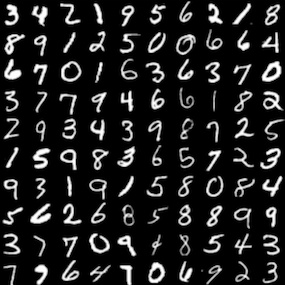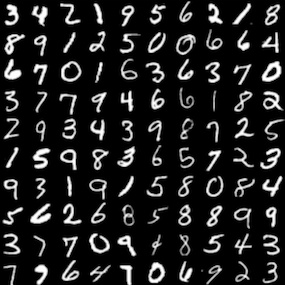

I went ahead and stored data in AWS S3 under folders, where each folder name is the label of the MNIST image.

In [ ]:
df = DataFrame.from_files("~/Downloads/mnist/testing/**")

In [ ]:
df.show(5)

In [ ]:
df = df.where(df["type"] != "directory")

Notice: Daft is lazy. `.where` returns immediately and Daft actually "queues" it up in a query plan which you can introspect into like so

Looks like the plan currently consists on a scan of some data that we hold in memory, followed by a filtering operation for our provided predicate!

In [ ]:
df.explain()

To execute the plan, we call `.show()`:

In [ ]:
df.show(5)

In [ ]:
df = df.select(df["name"])

In [ ]:
df

In [ ]:
df = df.with_column(
    "downloaded_bytes",
    df["name"].url.download(),
)

In [ ]:
df.show(5)

In [ ]:
import PIL.Image
import io

def to_pil_image(data: bytes) -> PIL.Image.Image:
    return PIL.Image.open(io.BytesIO(data))

df = df.with_column(
    "loaded_image",
    df["downloaded_bytes"].apply(to_pil_image)
)

In [ ]:
df.show(5)

### Hidden Cell: ML Model black magic

Defines a function `get_model()` that will return a neural network that will magically know how to classify MNIST images.

In [ ]:
###
# Model was trained using a script provided in PyTorch Examples: https://github.com/pytorch/examples/blob/main/mnist/main.py
###

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.hub
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def get_model():
    model = NeuralNetwork()
    state_dict = torch.hub.load_state_dict_from_url("https://github.com/Eventual-Inc/mnist-json/raw/master/mnist_cnn.pt")
    model.load_state_dict(state_dict)
    return model

In [ ]:
get_model()

In [ ]:
from daft import udf

import numpy as np

@udf(return_type=int)
def classify_images(images):
    # Get the model
    model = get_model()
    
    # Run the model on the batch of data
    images_2d = np.array([np.array(img) for img in images])
    normalized_image_2d = images_2d / 255
    normalized_image_2d = normalized_image_2d[:, np.newaxis, :, :]
    classifications = model(torch.from_numpy(normalized_image_2d).float())
    
    # Return the results
    return classifications.detach().numpy().argmax(axis=1)

In [ ]:
df = df.with_column(
    "model_classification",
    classify_images(df["loaded_image"]),
)

In [ ]:
df.show(5)

## How well is my model doing?

In [ ]:
df = df.with_column(
    "label",
    df["name"].apply(lambda name: int(name.split("/")[-2]), return_type=int)
)

In [ ]:
df.show(5)

In [ ]:
df = df.with_column(
    "mismatch",
    df["model_classification"] != df["label"],
)

In [ ]:
df.sum(df["mismatch"].cast(int)).show()

In [ ]:
df.groupby(df["label"]).sum(df["mismatch"].cast(int)).sort(df["label"]).show()